<a href="https://colab.research.google.com/github/kamilakesbi/notebooks/blob/main/synthetic_pipeline_diarizers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🤗 Generate synthetic speaker diarization datas with Diarizers


## Introduction

Speaker diarization systems often need extensive annotated data with multiple speakers for training, but such data is often scarce.

To address this limitation, recent research has focused on training speaker diarization systems using simulated datasets. These datasets are created by concatenating audio segments of individual speakers from ASR datasets to form artificial multi-speaker meetings.

We release a pipeline for synthetic speaker diarization dataset generation. This pipeline is compatible with 🤗[Diarizers](https://github.com/huggingface/diarizers), our library to fine-tune speaker diarization models.

In this tutorial, we introduce the pipeline, explaining its functionality and the various parameters it includes. We then demonstrate how to use it to fine-tune a pyannote speaker segmentation model for Japanese.

## Prepare environement

First of all, let's try to secure a decent GPU for our Colab! Unfortunately, it's becoming much harder to get access to a good GPU with the free version of Google Colab. However, with Google Colab Pro one should have no issues in being allocated a V100 or P100 GPU.

To get a GPU, click Runtime -> Change runtime type, then change Hardware accelerator from CPU to one of the available GPUs, e.g. T4 (or better if you have one available). Next, click Connect T4 in the top right-hand corner of your screen (or Connect {V100, A100} if you selected a different GPU).

We can verify that we've been assigned a GPU and view its specifications:

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu May 30 07:50:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

To use the synthetic pipeline, we will need to install `diarizers`.

`diarizers` library includes dependencies to `transformers`, `datasets`, `accelerate`, `pyannote.audio` and `torch`. We will need all these dependencies to run this notebook.

To install them all, simply run the following line of code, which will install the `diarizers` package:

In [ ]:
!pip install --upgrade --quiet git+https://github.com/kamilakesbi/diarizers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 873.5/873.5 kB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.5 MB/s eta 0:00:00
     ━━━━━

To create synthetic meetings from Automatic Speech Recognition datasets ( [Mutlilingual Librispeech](https://huggingface.co/datasets/facebook/multilingual_librispeech) / [CommonVoice](https://huggingface.co/datasets/mozilla-foundation/common_voice_17_0) / [Voxpopuli](https://huggingface.co/datasets/facebook/voxpopuli)) , you might need to accept their terms-of-use. To use this notebook, we will need to accept the terms-of-use of the Common-Voice dataset:

- [mozilla-foundation/common_voice_17_0](https://huggingface.co/datasets/mozilla-foundation/common_voice_17_0)


To load pre-trained diarization models from the Hub, you'll first need to accept the terms-of-use for the following model:

- [pyannote/segmentation-3.0](https://huggingface.co/pyannote/segmentation-3.0)


You'll then need to enter your
Hub authentication token. Find your Hub authentication token [here](https://huggingface.co/settings/tokens).

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## Choose an Automatic Speech Recognition dataset as a starting point

The pipeline uses Hugging Face [Automatic Speech Recognition]((https://huggingface.co/datasets?task_categories=task_categories:automatic-speech-recognition&sort=trending) datasets as a starting point.

To be compatible with the pipeline, the ASR dataset needs to contain at two features:  

- `audio`: Each audio segment must feature only one individual speaking.

- `speaker`: Associated to each audio segment, we must have access to a speaker id.

In this tutorial, we will use the japanese subset of the `common_voice_17_0` dataset to generate synthetic japanese meetings.

Lets first load the `common_voice_17_0` dataset and listen to an example:


In [ ]:
from datasets import load_dataset

dataset = load_dataset('mozilla-foundation/common_voice_17_0', 'ja', split='validated', streaming=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for mozilla-foundation/common_voice_17_0 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mozilla-foundation/common_voice_17_0
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the ne

In [ ]:
from IPython.display import Audio, display

example1 = next(iter(dataset))

print('Speaker id: ', example1['client_id'])

print('Audio: ')
display(Audio(example1['audio']['array'], rate=example1['audio']['sampling_rate']))

Reading metadata...: 93022it [00:02, 35871.61it/s]


Speaker id:  004a974ec0e77c3c846ac5d7dbef70cdd6329682f98c2ee7c14fd9a333a683d5f433d9beda70f415c5adabb80b220254b74b4eb6ab058b7b067c51ca8cb96c8a
Audio: 


The audio segment does contain a single speaker and we can access the associated speaker id.

The speaker ids will be useful when concatenating audio segments in the pipeline to annotate the generated synthetic meetings.

Lets now create a synthetic dataset from the common-voice dataset using `diarizers`. We will need to use two classes:

- `SyntheticDataset` is the main class to create synthetic datas. It takes instances from `SyntheticDatasetConfig` as input. It comes with a `generate` method that can be used to generate the synthetic dataset, as we will see later in this tutorial.

- `SyntheticDatasetConfig` is the configuration class associated to `SyntheticDataset`. This is where we define all the parameters associated to the synthetic meetings we want to generate. We will present most of them in this tutorial.  

To intanciate our first synthetic dataset, we specify the following parameters in `SyntheticDatasetConfig`:  

- `dataset_name`: name of the ASR dataset used as a starting point.  
- `subset`: subset of the ASR dataset (if there is one).  
- `split`: split of the ASR dataset (if there is one).
- `audio_column_name`: name of the audio column feature in the ASR dataset.
- `speaker_column_name`: name of the speaker column feature in the ASR dataset.

- `nb_speakers_from_dataset`: Number of speakers to keep for synthetic meeting generation. It will keep the speakers with most number of audio segments. Here, we set the value to -1 to keep all speakers.

- `min_samples_per_speaker`: Minimum number of audio segments associated with a speaker ID to be considered as a potential speaker in the generated meetings. This parameter is used to filter the ASR dataset and keep only audio segments from speakers with a sufficient number of audio segments. In the next example, we set this parameter to 10, meaning that we will only keep speakers with at least 10 audio segments for synthetic meeting generation.

- `sample_rate`: The sample of the target generated meetings.

Note that the other parameters will be set to default values. You find these values [here](https://github.com/kamilakesbi/diarizers/blob/7335fda972d2a00dcf8011b6a9855247e26fcdad/src/diarizers/data/synthetic_pipeline.py#L18).

In [16]:
from diarizers import SyntheticDataset, SyntheticDatasetConfig

synthetic_dataset_config = SyntheticDatasetConfig(
    dataset_name='mozilla-foundation/common_voice_17_0',
    subset='validated',
    split='ja',
    audio_column_name = "audio",
    speaker_column_name = "client_id",
    nb_speakers_from_dataset=-1,
    min_samples_per_speaker=10,
    sample_rate=16000,
)

synthetic_dataset = SyntheticDataset(synthetic_dataset_config)

nb speakers in dataset to keep: 1348


Filter (num_proc=2):   0%|          | 0/93022 [00:00<?, ? examples/s]

100%|██████████| 1348/1348 [00:00<00:00, 285840.33it/s]
Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /root/.cache/torch/hub/master.zip


When initiated, `SyntheticDataset` will filter the ASR dataset to only keep the relevant features (specified by `audio_column_name` and `speaker_column_name`), and samples associated to selected speakers (selected using `nb_speakers_from_dataset` and `min_samples_per_speaker`).

With this synthetic_dataset example, the number of speakers with at least 10 associated audio segments is 1348:  

In [17]:
print('Speakers that will be used for sampling: ', len(synthetic_dataset.speakers_to_sample_from))

Speakers that will be used for sampling:  1348


If we want to only keep the 200 speakers with most audio segments, we can do:

In [19]:
synthetic_dataset_config.nb_speakers_from_dataset=200

synthetic_dataset = SyntheticDataset(synthetic_dataset_config)

print('Speakers that will be used for sampling: ', len(synthetic_dataset.speakers_to_sample_from))

nb speakers in dataset to keep: 200


Filter (num_proc=2):   0%|          | 0/93022 [00:00<?, ? examples/s]

100%|██████████| 200/200 [00:00<00:00, 79152.75it/s]
Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /root/.cache/torch/hub/master.zip


Speakers that will be used for sampling:  200


##  Define the properties of the synthetic meetings

Before using the `generate` method to generate the synthetic meetings, there are a few other important parameters that needs to be specified:

- `num_meetings`: number of synthetic meetings to be generated.
- `nb_speakers_per_meeting`: Number of speakers per meeting. We will set this value to 3 in the following examples.
- `segments_per_meeting`: Number of audio segments per generated meeting. In the following examples, we will set this value to 16, which will generate ~1min meetings.
- `overlap_proba`: Probablity of having overlap between successive speakers.
- `silence_proba`: Probability of having regions of silence (where no speaker's talking) in a generated meeting.

Let's generate a first synthetic meeting examples:  

In [23]:
synthetic_dataset_config = SyntheticDatasetConfig(
    dataset_name='mozilla-foundation/common_voice_17_0',
    subset='validated',
    split='ja',
    min_samples_per_speaker=10,
    audio_column_name = "audio",
    speaker_column_name = "client_id",
    nb_speakers_from_dataset=3,
    num_meetings=2,
    nb_speakers_per_meeting=3,
    segments_per_meeting=16,
    overlap_proba=0,
    silence_proba=0,
    num_proc=1,
)

synthetic_dataset = SyntheticDataset(synthetic_dataset_config).generate()

nb speakers in dataset to keep: 3


Filter:   0%|          | 0/93022 [00:00<?, ? examples/s]

100%|██████████| 3/3 [00:00<00:00, 1850.70it/s]
Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /root/.cache/torch/hub/master.zip
100%|██████████| 2/2 [00:00<00:00, 76.28it/s]


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Let's listen to the generated meeting, and visualize the associated speaker timestamps:

In [27]:
example1 = synthetic_dataset[0]

display(Audio(example1['audio']['array'], rate=example1['audio']['sampling_rate']))

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def plot_meeting(dataset, sample = 0, x_start = None, x_end= None, save = False):

    timestamps_start = dataset[sample]['timestamps_start']
    timestamps_end = dataset[sample]['timestamps_end']
    speakers = dataset[sample]['speakers']
    print(len(timestamps_start))
    speaker_labels = list(set(speakers))

    per_speaker_timestamps = {}

    for speaker_to_filter in speaker_labels:

        indices = [i for i, spk in enumerate(speakers) if spk == speaker_to_filter]

        timestamps_start_spk = [timestamps_start[i] for i in indices]
        timestamps_end_spk = [timestamps_end[i] - timestamps_start[i] for i in indices]

        per_speaker_timestamps[speaker_to_filter] = list(zip(timestamps_start_spk, timestamps_end_spk))

    # Set up the figure and axis
    fig, ax = plt.subplots(figsize = (10, 5))
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
    colors += ['#{:06x}'.format(np.random.randint(0, 16777215)) for _ in range(len(speaker_labels) - 4)]

    i = 0
    labels = []
    label_positions = []

    for key, value in per_speaker_timestamps.items():
        ax.broken_barh(value, (0.3*i, 0.5), facecolors = colors[i])
        label_positions.append(0.3*i + 0.25)
        i+=1
        labels.append(key)

    ax.set_xlabel('seconds since start')
    ax.set_xlim(x_start, x_end)
    ax.set_yticks(label_positions, labels=[i for i in range(len(speaker_labels))])
    ax.set_ylabel('speaker')
    ax.grid(True)

    plt.title('dataset: {} - sample number {}'.format(dataset.info.dataset_name, sample))
    if save == True:
        plt.savefig('{}_{}.png'.format(dataset.info.dataset_name, sample))
    plt.show()


19


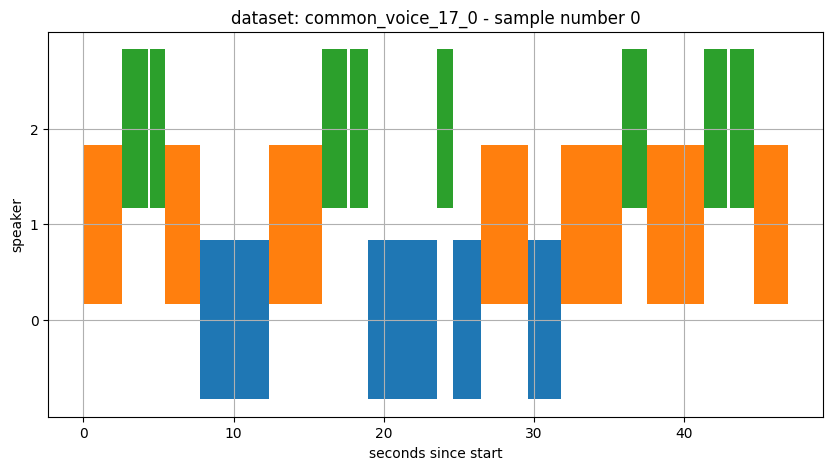

In [29]:
plot_meeting(synthetic_dataset, sample=0)

Nice! we just generated a 47 seconds synthetic meeting with 3 talking speakers :) We can see that, as specified by the configuration, there is no overlap between successive speakers and no regions of silence!

To understand how we get that result, let's break down the main steps of the algorithm:

- First, a sampling algorithm is used to select the audio segments used for each generated meeting: It will start by sampling randomly `nb_speakers_per_meeting` from the filtered ASR dataset, and iteratively fill an empty batch with sampled audio segments from the selected speakers. It will make sure no audio segments is used twice in a generated meeting and that successive audio segments belong to different speakers.

- To get precise speaker timestamps with each audio segment, timestamps are refined unsing a Voice Activity Detector. We will also crop the beginning and end of each audio segment to remove undesirable regions of silences.

- Once the meeting batch of refined audio segments has been generated, we can start concatenating them. To simulate natural human conversation, a small gap pause is inserted between successive speaker turns and sampled from a Rayleigh distribution with scale parameter (mode) of 200ms. This is inspired by published statistics of natural conversation ([Heldner, M., Edlund, J: Pauses, gaps and overlap in conversations, 2010](https://www.sciencedirect.com/science/article/abs/pii/S0095447010000628)). After this step, we obtain our generated audio meetings with corresponding annotations.


A few optionnal steps might be added:

- Using the parameters of the pipeline, we can add overlap between successive audio segments or regions of silences in the final generated meeting.

- We can play with the gain of each segment to give more volume to some speakers.

- We can also choose to denoise the final generated meeting to keep only speaker voices. Indeed, recording conditions might differ from an audio segment to another and it might be useful to denoise the final meeting to make sure there is no background noise mismatch between successive segments.

- We can also choose to augment the generated meetings with background noise and reverberation.

### Adding silence and overlap:

Let's add silence and overlap to the generated meetings. Here, we modify the following parameters:

- `overlap_proba`: we set this value to 0.3. It means that there is a 30 % probability that two successive audio segments will be overlapping.
- `overlap_length`: It correspond to the maximum overlap duration between two successive audio segments overlapping. We set this value to 3 seconds here.
- `silence_proba`: Probability of having one region of silence in the generated meeting. We set this value to 1 here to make sure we will have a region of silence in the generated meeting.
- `silence_duration`: Maximum duration of the region of silence. We set this value to 2 seconds.  

In [40]:
synthetic_dataset_config.overlap_proba = 0.5
synthetic_dataset_config.overlap_length = 3

synthetic_dataset_config.silence_proba = 1
synthetic_dataset_config.silence_duration = 2

In [41]:
synthetic_dataset = SyntheticDataset(synthetic_dataset_config).generate()

nb speakers in dataset to keep: 3


Filter:   0%|          | 0/93022 [00:00<?, ? examples/s]

100%|██████████| 3/3 [00:00<00:00, 6410.04it/s]
Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /root/.cache/torch/hub/master.zip
100%|██████████| 2/2 [00:00<00:00, 91.08it/s]


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Let's listen and visualize the generated meeting:

In [42]:
from IPython.display import Audio, display

example = synthetic_dataset[0]

display(Audio(example['audio']['array'], rate=example['audio']['sampling_rate']))

19


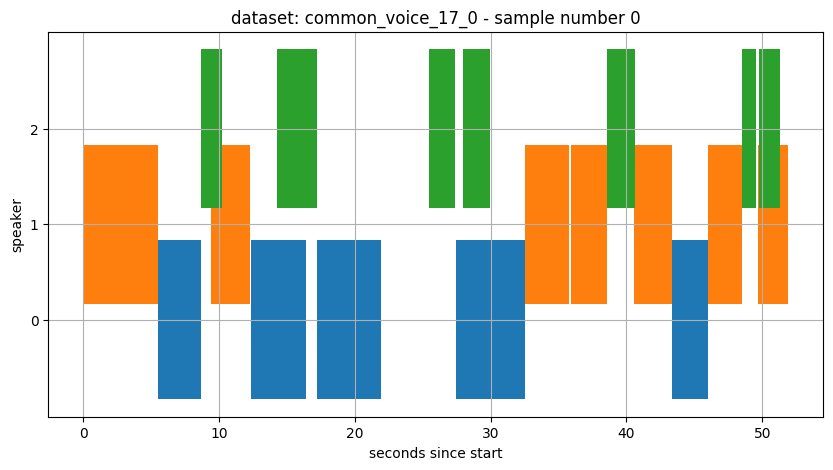

In [43]:
plot_meeting(synthetic_dataset, sample=0)

We can see that we have indeed forced overlap between speakers and added a region of silence 🤗. We can play with these hyperparameters to obtain synthetic dataset with the overlap and silence proportions we need!

As mentionned previously, we can play with the other parameters if we want to augment our synthetic dataset with background noise, reverberatio or gain. Feel free to experiment!

## Training

Let's create a large synthetic dataset that we will use for fine-tuning a pyannote speaker segmentation model. We will create a dataset with 800 generated meetings and 3 speakers per meeting.

Here are all the hyperparameters we will use to generate this dataset:  

In [44]:
synthetic_dataset_config = SyntheticDatasetConfig(
    dataset_name =  "mozilla-foundation/common_voice_17_0",
    subset = "validated",
    split = "ja",
    speaker_column_name = "client_id",
    audio_column_name = "audio",
    min_samples_per_speaker = 10,
    nb_speakers_from_dataset = 200,
    sample_rate  = 16000,
    num_meetings = 800,
    nb_speakers_per_meeting = 3,
    segments_per_meeting = 16,
    normalize = True,
    overlap_proba = 0.3,
    overlap_length = 3,
    random_gain = False,
    add_silence = True,
    silence_duration = 3,
    silence_proba = 3,
    denoise = False,
    num_proc = 2
)

In [ ]:
synthetic_dataset = SyntheticDataset(synthetic_dataset_config).generate()

nb speakers in dataset to keep: 200


Filter (num_proc=2):   0%|          | 0/93022 [00:00<?, ? examples/s]

100%|██████████| 200/200 [00:00<00:00, 42923.85it/s]
Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /root/.cache/torch/hub/master.zip
  9%|▉         | 73/800 [00:05<02:03,  5.88it/s]

We can push this dataset to the Hub:

In [ ]:
synthetic_dataset.push_to_hub("speaker-diarization-synthetic-jpn")

4. Train with a synthetic dataset from the Hub:

In [ ]:
dataset = load_dataset('kamilakesbi/speaker-diarization-synthetic-jpn')

Generating train split:   0%|          | 0/1584 [00:00<?, ? examples/s]

In [ ]:
from datasets import DatasetDict

train_testvalid = dataset['train'].train_test_split(test_size=0.2, seed=0)
test_valid = train_testvalid['test'].train_test_split(test_size=0.5, seed=0)

dataset = DatasetDict({
    'train': train_testvalid['train'],
    'validation': test_valid['test'],
    'test': test_valid['train']}
)

In [ ]:
from pyannote.audio import Model

pretrained = Model.from_pretrained(
  "pyannote/segmentation-3.0",
  use_auth_token=True
)

pytorch_model.bin:   0%|          | 0.00/5.91M [00:00<?, ?B/s]

config.yaml:   0%|          | 0.00/399 [00:00<?, ?B/s]

In [ ]:
from diarizers import SegmentationModel

model = SegmentationModel.from_pyannote_model(pretrained)

In [ ]:
from diarizers import Preprocess

preprocessor = Preprocess(model.config)

In [ ]:
train_set = dataset['train'].map(
    lambda file: preprocessor(file, random=False, overlap=0.5),
    num_proc=2,
    remove_columns=next(iter(dataset.values())).column_names,
    batched=True,
    batch_size=1
).with_format("torch")

val_set = dataset['validation'].map(
    lambda file: preprocessor(file, random=False, overlap=0.0),
    num_proc=2,
    remove_columns=next(iter(dataset.values())).column_names,
    batched=True,
    batch_size=1
).with_format('torch')

Map (num_proc=2):   0%|          | 0/1267 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/159 [00:00<?, ? examples/s]

In [ ]:
from diarizers import DataCollator

data_collator = DataCollator(max_speakers_per_chunk=model.config.max_speakers_per_chunk)

In [ ]:
from diarizers import Metrics

metrics = Metrics(model.specifications)

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./speaker-segmentation-fine-tuned-synthetic-jpn',
    save_strategy="epoch",
    learning_rate=1e-3,
    num_train_epochs=5,
    lr_scheduler_type="cosine",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy="epoch",
    gradient_accumulation_steps=1,
    dataloader_num_workers=2,
    logging_steps=25,
    load_best_model_at_end=True,
    seed=42,
    push_to_hub=True,
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_set,
    data_collator=data_collator,
    eval_dataset=val_set,
    compute_metrics=metrics,
)

In [ ]:
first_eval = trainer.evaluate()
first_eval

In [ ]:
trainer.train()

In [ ]:
kwargs = {
    "dataset_tags":'diarizers-community/callhome',
    "dataset_args": "config: jpn",
    "language": "jpn",
    "model_name": "speaker-segmentation-fine-tuned-callhome-jpn",
    "finetuned_from": "pyannote/speaker-diarization-3.1",
    "tasks": "speaker-diarization",
    "tags": ['speaker-diarization', 'speaker-segmentation']
}

In [ ]:
trainer.push_to_hub(**kwargs)

### Closing remarks: